# T4 Lysozyme RBFE with OpenMM and OpenFE tutorial

This example notebook demonstrates how to carry out a relative free energy calculation of the transformation between benzene and phenol in the T4 lysozyme binding site.

## Conventional MD of the benzene system

In the first instance we outline how to run a short conventional MD simulation of one of the ligands using the OpenFF toolkit. This tutorial is inspired by the OpenFF ["using sminorff with AMBER protein forcefield"](https://github.com/openforcefield/openff-toolkit/blob/stable/examples/using_smirnoff_with_amber_protein_forcefield/toluene_in_T4_lysozyme.ipynb).and ["toolkit showcase"](https://github.com/openforcefield/openff-toolkit/blob/stable/examples/toolkit_showcase/toolkit_showcase.ipynb) example notebooks.

In [16]:
# openmm imports
import openmm
from openmm import app, unit
from openmm.app import PME, HBonds, PDBFile, Modeller

# openff imports
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
from openff.toolkit.utils import get_data_file_path
from openmmforcefields.generators import SMIRNOFFTemplateGenerator

# numpy
import numpy as np

# parmed
import parmed

# rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

# viz
import nglview as nv
import mdtraj as mdt
import MDAnalysis as mda

from tqdm import tqdm
import matplotlib
%matplotlib inline

In [17]:
# Set force field parameters
omm_forcefield = app.ForceField('amber99sb.xml', 'tip3p.xml')

# Create protein system
prot_pdb = PDBFile('inputs/181L_mod_capped_protonated.pdb')
modeller = Modeller(prot_pdb.topology, prot_pdb.positions)

In [3]:
# Create ligand
ligand = Molecule.from_file('inputs/benzene.sdf')
ligand_positions = ligand.conformers[0]
ligand_topology = ligand.to_topology()

smirnoff = SMIRNOFFTemplateGenerator(forcefield="openff-2.0.0.offxml",
                                     molecules=[ligand])
omm_forcefield.registerTemplateGenerator(smirnoff.generator)

In [ ]:
# Add ligand to the Modeller instance
modeller.add(ligand_topology.to_openmm(), ligand_positions)

# Solvate in 0.15 M NaCl
## Todo - long term switch to saltpy-like approach
modeller.addSolvent(omm_forcefield, model='tip3p', padding=1.2*unit.nanometer, ionicStrength=0.15*unit.molar)

# Create OpenMM system + topology + initial positions
system = omm_forcefield.createSystem(
    modeller.topology,
    nonbondedMethod=PME,
    nonbondedCutoff=0.9 * unit.nanometer,
    constraints=HBonds,
    rigidWater=True)

topology = modeller.getTopology()
positions = modeller.getPositions()

# The box is about 73 angstroms per side, so add (30, 30, 30) to center the protein
positions = modeller.getPositions() + np.array([30, 30, 30]) * unit.angstrom

In [ ]:
# configure and run a short simulation
integrator = openmm.LangevinIntegrator(298.15 * unit.kelvin, 1 / unit.picosecond, 0.002 * unit.picoseconds)
simulation = app.Simulation(topology, system, integrator)
simulation.context.setPositions(positions)

nc_reporter = parmed.openmm.NetCDFReporter("short-trajectory.nc", 100)
simulation.reporters.append(nc_reporter)

In [ ]:
# visualise the built system
u = mda.Universe(simulation)
view = nv.show_mdanalysis(u)
view.display(gui=True)
view

In [ ]:
# Do a short energy minimisation followed by a short NVT simulation
simulation.minimizeEnergy()
minimized_state = simulation.context.getState(
    getPositions=True, getEnergy=True, getForces=True
)

# NVT simulations at 298.15 Kelvin
simulation.context.setVelocitiesToTemperature(298.15 * unit.kelvin)
simulation.step(500)

## Exploring the ligands and their atom mappings

Now that we have a base understanding of how to build one of the end states, we next look at the ligand pair for which we wish to capture a relative binding free energy.

In order to morph between the two ligands, we need to create a hybrid system that distinguishes between common (also often known as core) atoms, and those that will be either disappearing or appearing. To achieve this we create an atom mapping which identifies these common atoms.

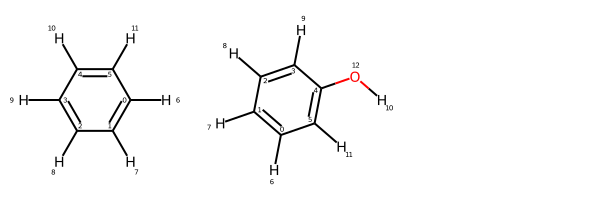

In [18]:
# First let's have a look at our two ligands
benz_mol = Chem.SDMolSupplier('inputs/benzene.sdf', removeHs=False)[0]
phen_mol = Chem.SDMolSupplier('inputs/phenol.sdf', removeHs=False)[0]

# Let's make a copy and look at them in 2D
from copy import deepcopy
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True


m1 = deepcopy(benz_mol)
m2 = deepcopy(phen_mol)

AllChem.Compute2DCoords(m1)
AllChem.Compute2DCoords(m2)

Chem.Draw.MolsToGridImage([m1, m2])

mapping:  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 12, 11: 11}


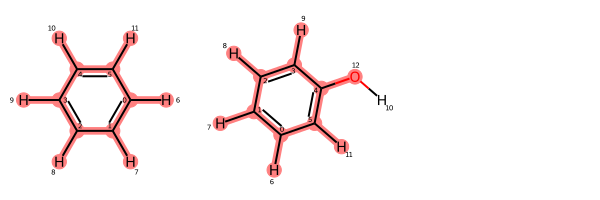

In [19]:
# Next we create an atom mapping between the two molecules using the OpenFE
# toolkit and the Lomap mapper
import openfe
from openfe.setup.lomap_mapper import LomapAtomMapper

mapper = LomapAtomMapper(threed=True)
mapping = next(mapper.suggest_mappings(benz_mol, phen_mol))

# this is a very simple case so all the atoms match each other directly.
print("mapping: ", mapping.mol1_to_mol2)

# Quick temporary hack until Henry's solution gets added
m1_matched_idx = list(mapping.mol1_to_mol2.keys())
m2_matched_idx = list(mapping.mol1_to_mol2.values())

Chem.Draw.MolsToGridImage([m1, m2],
                          highlightAtomLists=[m1_matched_idx, m2_matched_idx])

## Creating a Hybrid Topology for alchemical simulations

Now that we have an atom mapping, we can use it to create a hydrid topology
which contains the force field information for both our ligands at the same
time.

Several of the imported methods here are adapted versions of those found in
Perses. The short term aim is that some of these will find their way to either
the main OpenFE repository, or OpenMMTools.

In [20]:
# First let's create our OFF Molecules for both rdkit molecules
# TODO - just load from the OpenFE molecule once the backend is finalised
benzene_off = Molecule.from_rdkit(benz_mol)
benzene_top = benzene_off.to_topology()
benzene_pos = benzene_off.conformers[0]

phenol_off = Molecule.from_rdkit(phen_mol)
phenol_top = phenol_off.to_topology()
phenol_pos = phenol_off.conformers[0]

In [21]:
# Next we create an OpenMM System for the "old" (benzene) alchemical endstate

# first register an ommff generator with the required topology
smirnoff1 = SMIRNOFFTemplateGenerator(
    forcefield="openff-2.0.0.offxml", molecules=[benzene_off])
omm_forcefield1 = app.ForceField('amber99sb.xml', 'tip3p.xml')
omm_forcefield1.registerTemplateGenerator(smirnoff1.generator)

# Create Modeller object
old_modeller = Modeller(prot_pdb.topology, prot_pdb.positions)
old_modeller.add(benzene_top.to_openmm(), benzene_pos)
old_modeller.addSolvent(
    omm_forcefield1, model='tip3p', padding=1.2*unit.nanometer,
    ionicStrength=0.15*unit.molar)

# Create OpenMM system + topology + initial positions for "old" system
old_system = omm_forcefield1.createSystem(
                old_modeller.topology,
                nonbondedMethod=PME,
                nonbondedCutoff=0.9 * unit.nanometer,
                constraints=HBonds,
                rigidWater=True)


old_topology = old_modeller.getTopology()
old_positions = old_modeller.getPositions()

# TODO - better explain this: see OpenFF examples
# The box is about 73 angstroms per side, so add (30, 30, 30) to center the protein
old_positions = old_modeller.getPositions() + np.array([30, 30, 30]) * unit.angstrom

INFO:	Requested to generate parameters for residue <Residue 164 (benzene) of chain 1>
INFO:	Generating a residue template for [H]c1c(c(c(c(c1[H])[H])[H])[H])[H] using openff-2.0.0.offxml
INFO:	24 torsions added
INFO:	6 impropers added, each applied in a six-fold trefoil
INFO:	12 bonds added (0 skipped due to constraints)
INFO:	18 angles added (0 skipped due to constraints)


In [22]:
# Next we create a topology for the "new" (phenol) system, using the "old"
# (benzene) OpenMM Topology
from utils import setup

# Essentially we remove the benzene residue from the old topology and graft
# in the new phenol residue
new_topology = setup.append_new_topology_item(old_topology,
                                              phenol_top.to_openmm(),
                                              exclude_residue_name="benzene")

In [23]:
# Next we create the OpenMM System for our "new" (phenol) system

# first register an ommff generator with the required topology
smirnoff2 = SMIRNOFFTemplateGenerator(
    forcefield="openff-2.0.0.offxml", molecules=[phenol_off])
omm_forcefield2 = app.ForceField('amber99sb.xml', 'tip3p.xml')
omm_forcefield2.registerTemplateGenerator(smirnoff2.generator)

new_system = omm_forcefield2.createSystem(
                 new_topology,
                 nonbondedMethod=PME, nonbondedCutoff=0.9 * unit.nanometer,
                 constraints=HBonds, rigidWater=True)

INFO:	Requested to generate parameters for residue <Residue 11856 (phenol) of chain 4>
INFO:	Generating a residue template for [H]c1c(c(c(c(c1[H])[H])O[H])[H])[H] using openff-2.0.0.offxml
INFO:	26 torsions added
INFO:	6 impropers added, each applied in a six-fold trefoil
INFO:	13 bonds added (0 skipped due to constraints)
INFO:	19 angles added (0 skipped due to constraints)


In [24]:
# We next get the adjusted atom mapping between our systems
mappings = setup.get_system_mappings(mapping.mol1_to_mol2,
                                     old_system, old_topology, "benzene",
                                     new_system, new_topology, "phenol",
                                     fix_constraints=False,
                                     remove_element_changes=True)

/home/bioc1523/github/openmm-rbfe/utils/setup.py:323: UserWarning: Not attempting to fix atom mapping to account for constraints. Please note that core atoms which have constrained bonds and changing bond lengths are not allowed.
  warnings.warn(wmsg)


In [25]:
new_positions = setup.set_and_check_new_positions(
                    mappings, old_topology, new_topology, old_positions,
                    insert_positions=phenol_pos,
                    shift_insert=np.array([30, 30, 30]))

In [26]:
from utils import relative

hybrid_factory = relative.HybridTopologyFactory(
                     old_system, old_positions, old_topology,
                     new_system, new_positions, new_topology,
                     old_to_new_atom_map=mappings['old_to_new_atom_map'],
                     old_to_new_core_atom_map=mappings['old_to_new_core_atom_map'],
                     use_dispersion_correction=False,
                     softcore_alpha=0.5,
                     softcore_LJ_v2=True,
                     softcore_LJ_v2_alpha=0.85,
                     softcore_electrostatics=True,
                     softcore_electrostatics_alpha=0.3,
                     softcore_sigma_Q=1.0,
                     interpolate_old_and_new_14s=False,
                     flatten_torsions=False,)

# Also add a barostat
hybrid_factory.hybrid_system.addForce(
    openmm.MonteCarloBarostat(1.0, 298.15, 50))

INFO:	creating hybrid system
INFO:	setting force field terms
INFO:	adding forces
INFO:	DONE


9

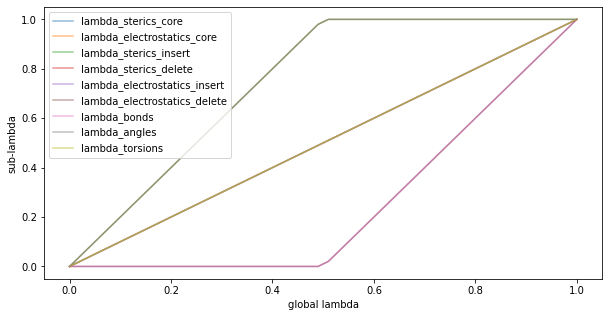

In [30]:
# Get a lambda protocol
# Here we use the default protocol as implemented in Perses
# ele and LJ terms of the old system are turned off between 0.0 -> 0.5
# ele and LJ terms of the new system are turned on between 0.5 -> 1.0
# core terms are treated linearly
from utils import lambda_protocol

lambdas = lambda_protocol.LambdaProtocol(functions="default", windows=10)
lambdas.plot_functions()


In [ ]:
# Next we set our multi state reporter - we'll go for 10 windows
from openmmtools.multistate import MultiStateReporter

selection_indices = hybrid_factory.hybrid_topology.select('all')
reporter = MultiStateReporter('rbfe.nc',
                              analysis_particle_indices=selection_indices,
                              checkpoint_interval=100)

In [ ]:
# Get the platform and context caches
from utils import compute

platform = compute.get_openmm_platform()
energy_context_cache = cache.ContextCache(capacity=None, time_to_live=None, platform=platform)
                sampler_context_cache = cache.ContextCache(capacity=None, time_to_live=None, platform=platform)

In [13]:
from openmmtools import integrators



integrator = integrators.LangevinIntegrator(temperature=298.15 * unit.kelvin,
                                            collision_rate=1.0/unit.picosecond,
                                            timestep=2.0*unit.femtosecond)

context = openmm.Context(hybrid_factory.hybrid_system, integrator)
context.setPositions(hybrid_factory.hybrid_positions)

In [27]:
context.setVelocitiesToTemperature(298.15)

In [14]:
openmm.LocalEnergyMinimizer.minimize(context, maxIterations=100000)

In [15]:
state = context.getState(getPositions=True, getEnergy=True, getForces=True)

In [16]:
print(max(np.sqrt(v.x * v.x + v.y * v.y + v.z * v.z) for v in state.getForces()),
state.getForces().unit.get_symbol())

2538.5646852704535 kJ/(nm mol)


In [17]:
integrator.step(500)

In [42]:
state = context.getState(getPositions=True, getEnergy=True, getForces=True)

In [53]:
pos = state.getPositions(asNumpy=True)

NameError: name 'system' is not defined